In [1]:
import torch
import IPython.display as ipd
# from Prop import Prop
from Prop_mixture import Prop_mixture
from Baseline_new import Baseline_new
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from Blocks import BasicBlock, Bottleneck, ChannelChange, Bottleneck_new
import os
import librosa
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

/media/sdb1/hy17/venv/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [2]:

# model_oldsr = torch.load('../Final_Models/0513_230921ratio_sr32_d6_5db.model') 
# model_oldsr = torch.load('../Final_Models/0513_221509ratio_sr32_d6_5db.model')
# model_newsr = torch.load('Final_Models/0602_123426ratio_sr24_d6_5db.model')
# model_newNonSR = torch.load('0617_175014_24_d6_5db.model')
# # model_newprop = torch.load('Final_Models/0602_123426ratio_sr24_d6_5db.model')
# # model_newbase = torch.load('0606_214529_baseline_sr32_d3_5db.model')

# model1 = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0511_025544_sr32_d3.model')
# model_24 = torch.load('../Final_Models/0602_022246ratio_sr24_d6_0db.model')
# model_24_base = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0510_142628_baseline_sr32_d3.model')
# model_16 = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0509_sr8_d3.model')
# model_16_base = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0511_023814_baseline_sr16_d3.model')
# model_8 = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0511_131846_s16_d3.model')
# model_8_base = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0513_133044_baseline_sr32_d3_0db.model')
# model_8_base = torch.load('/media/sdb1/hy17/Projects/SANAC_backup/SANAC/Final_Models/0511_141723_baseline_sr16_d3.model')

# model_base_sr = torch.load('../models/1109_155434_32_d6_0db_Base_stage0.model')
# model_base = torch.load('../models/1109_215511_32_d6_0db_Base_stage0.model')

# model_stage0 = torch.load('../models/1117_114314_32_d6_0db_Base.model')

# model_ept0 = torch.load('../models/1110_101415_32_d6_0db_Prop_stage1ept0.model')


In [3]:
def load_trim(wavpath, n, db=0, overlap=64, window_in_data = False):
    
    window = np.hamming(overlap*2) 
    window = np.concatenate((window[:overlap],np.ones(512-overlap*2),window[overlap:]))
    window = window.reshape(1,-1)
    window = window.astype(np.float32)
    
    max_x = 31.61
    
    try:
        c, cr = librosa.load(wavpath, sr = None)
        c /= np.std(c)
    except OSError:
        print('errorfile:',wavpath)
    
    n = n[len(n)//2:len(n)//2+len(c)]        
        
    scalar = 10.0 ** (0.05 * (db))
    n /= np.std(n)* scalar
        
#     n /= max(abs(c))
#     c /= max(abs(c))
    x = c + n
    
    c_l = []
    x_l = []
    
    for i in range(0, len(c), 512 - overlap):
        if i + 512 > len(c):
            break
        c_l.append(c[i:i+512])
        x_l.append(x[i:i+512])
    c_l = np.array(c_l)
    x_l = np.array(x_l)
    c = c[:len(c_l)*(512-overlap)+overlap]
    x = x[:len(c)]
    
    if window_in_data:
        c_l = c_l * window
        x_l = x_l * window

    return c/max_x, x/max_x, c_l/max_x, x_l/max_x


def load_trim_clean(wavpath, overlap=64, window_in_data = False):
    
    window = np.hamming(overlap*2) 
    window = np.concatenate((window[:overlap],np.ones(512-overlap*2),window[overlap:]))
    window = window.reshape(1,-1)
    window = window.astype(np.float32)
    
    max_c = 22.5455
    
    try:
        c, cr = librosa.load(wavpath, sr = None)
        c /= np.std(c)
    except OSError:
        print('errorfile:',wavpath)
    
    c_l = []
    
    for i in range(0, len(c), 512 - overlap):
        if i + 512 > len(c):
            break
        c_l.append(c[i:i+512])
    c_l = np.array(c_l)
    c = c[:len(c_l)*(512-overlap)+overlap]
    
    if window_in_data:
        c_l = c_l * window

    return c/max_c, c_l/max_c

def rebuild(output, overlap = 64):
    
    output = output.cpu()
    len_wav = len(output) * (512 - overlap) + overlap
    wave = torch.zeros(len_wav)
    for i in range(len(output)):
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i]       
    
    return wave

def rebuild_window(output, overlap = 64):
    output = output.detach().cpu().data.numpy() # shape - (bt, 512)
    len_wav = len(output) * (512 - overlap) + overlap
    
    window = np.hamming(overlap*2) 
    window = np.concatenate((window[:overlap],np.ones(512-overlap*2),window[overlap:]))
    window = window.reshape(1,-1)
    window = window.astype(np.float32)
    
    output *= window
    wave = torch.zeros(len_wav)
    for i in range(len(output)):
#         print(i)
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i] 
    
    return wave

def SDR(s, sr): # input (50, 512), (50, 512)
    
    eps=1e-20
    s = s.cpu().data.numpy()
    sr = sr.cpu().data.numpy()
    sdr = 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)
    
    return sdr

def SISDR(s,sr,  cuda = False):
    
    eps = 1e-20
    scale = torch.sum(sr * s, dim = 1) / torch.sum(s**2, dim = 1) 
    scale = scale.unsqueeze(dim = 1) # shape - [50,1]
    s = s * scale
    sisdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    if cuda:
        return torch.mean(sisdr)
    else:
        return torch.mean(sisdr).cpu().data.numpy()
    
import collections
def entropy(arg):
    entropy = 0
    counter = collections.Counter(arg)
    sum_v = sum(counter.values())
    for value in counter.values():
        p = value / sum_v
        entropy += - np.log(p)*p
    return entropy


In [4]:
def gen_sound(i=0,db=0, window_in_data=False):
    wavpath0 = '/media/sdc1/Data/timit-wav/test/dr5/mrws1/sx140.wav'
    wavpath1 = '/media/sdc1/Data/timit-wav/test/dr1/faks0/sa1.wav'
    wavpath2 = '/media/sdc1/Data/timit-wav/test/dr1/mreb0/sa2.wav'
    wavpath3 = '/media/sdc1/Data/timit-wav/test/dr3/mkch0/sx28.wav'
    wavpath4 = '/media/sdc1/Data/timit-wav/test/dr3/fkms0/sx50.wav'
    wavpath5 = '/media/sdc1/Data/timit-wav/test/dr5/fjcs0/sx139.wav'
    wavpath6 = '/media/sdc1/Data/timit-wav/test/dr4/fsem0/sx28.wav'
    wavpath7 = '/media/sdc1/Data/timit-wav/test/dr4/mkcl0/sx191.wav'
    wavpath8 = '/media/sdc1/Data/timit-wav/test/dr6/flnh0/sx134.wav'
    wavpath9 = '/media/sdc1/Data/timit-wav/test/dr6/mesd0/sx12.wav'

    path_name = [wavpath0, wavpath1, wavpath2,wavpath3,wavpath4,wavpath5,wavpath6,wavpath7,wavpath8,wavpath9]
    # n_idx = [2, -1, -3, -4, 5, 1]

    # idx = 4
    names = ['birds', 'computerkeyboard', 'jungle', 'ocean', 'casino', 'eatingchips', 'machineguns',\
                     'cicadas', 'frogs', 'motorcycles']
#     i = 1
    path = path_name[i]
    noise_path = '/media/sdc1/Data/Duan/{}.wav'.format(names[i])
    n, nr = librosa.load(noise_path, sr=None)
    # tes, sr = librosa.load(wavpath5, sr=None)

#     db = 5
    c, x, c_l, x_l = load_trim(path, n, db=db, window_in_data=window_in_data)

    c_l = torch.Tensor(c_l)
#     c = torch.Tensor(c)
    x_l = torch.Tensor(x_l)
    #         x = torch.Tensor(x)
    
    return c, x, c_l, x_l

In [5]:
def gen_clean_sound(i=0,window_in_data=False):
    wavpath0 = '/media/sdc1/Data/timit-wav/test/dr5/mrws1/sx140.wav'
    wavpath1 = '/media/sdc1/Data/timit-wav/test/dr1/faks0/sa1.wav'
    wavpath2 = '/media/sdc1/Data/timit-wav/test/dr1/mreb0/sa2.wav'
    wavpath3 = '/media/sdc1/Data/timit-wav/test/dr3/mkch0/sx28.wav'
    wavpath4 = '/media/sdc1/Data/timit-wav/test/dr3/fkms0/sx50.wav'
    wavpath5 = '/media/sdc1/Data/timit-wav/test/dr5/fjcs0/sx139.wav'
    wavpath6 = '/media/sdc1/Data/timit-wav/test/dr4/fsem0/sx28.wav'
    wavpath7 = '/media/sdc1/Data/timit-wav/test/dr4/mkcl0/sx191.wav'
    wavpath8 = '/media/sdc1/Data/timit-wav/test/dr6/flnh0/sx134.wav'
    wavpath9 = '/media/sdc1/Data/timit-wav/test/dr6/mesd0/sx12.wav'

    path_name = [wavpath0, wavpath1, wavpath2,wavpath3,wavpath4,wavpath5,wavpath6,wavpath7,wavpath8,wavpath9]
    path = path_name[i]
    
    c, c_l = load_trim_clean(path, window_in_data=window_in_data)

    c_l = torch.Tensor(c_l)
    
    return c, c_l

In [186]:
def generate_result(model, x_l, window_in_data):
    model.eval()
    n_h = None
#     s_h, n_h, prob_s, prob_n = model(x_l.cuda(),soft = False)
    output = model(x_l.cuda(),soft = True)
    
    if window_in_data:
        rebuild_f = rebuild
    else:
        rebuild_f = rebuild_window
        
    s_h = output[0]
    if len(output) == 4:
        n_h = output[1]        
        
    rs = rebuild_f(s_h).cpu().data.numpy()
    if not isinstance(n_h, type(None)):
        rx = rebuild_f(s_h+n_h).cpu().data.numpy()
    else:
        rx = rs
    
    return rs, rx

**Old SR**

In [187]:
window_in_data = False
# model_1= torch.load('../models/1221_190850_32_d1_0db_Base.model') # noSR
# model_2= torch.load('../models/1221_192143_32_d3_0db_Base_stage1ept0.model') # noSR

# model_2 = torch.load('../models/1220_193421_32_d6_0db_Prop.model') # SR

# model2_0 = torch.load('../models/0106_125430_32_d3__Base_stage0.model') # noSR mixture
# model2_1 = torch.load('../models/0106_125430_32_d3__Base_stage1ept0.model')
# model2_2 = torch.load('../models/0106_125430_32_d3__Base.model')
model = torch.load('../models/0108_155025_32_d1__Base_epoch6.model')

In [188]:
# c, x, c_l, x_l = gen_sound(i=1, db=0, window_in_data=window_in_data)
# ipd.Audio(x/max(x), rate = 16000)
c, c_l = gen_clean_sound(i=1, window_in_data=window_in_data)
ipd.Audio(c/max(c), rate = 16000)
# sf.write('../testuttr/uttr1_original.wav',  x/max(x), 16000, 'PCM_24')
# librosa.output.write_wav('../testuttr/uttr1_original.wav', x/max(x), 16000)

In [189]:
rs1, rx1 = generate_result(model, c_l, window_in_data=window_in_data)
# import soundfile as sf
# sf.write('../testuttr/uttr1_base_final_noSR.wav',  rx1/max(rx1), 16000, 'PCM_24')
# librosa.output.write_wav('../testuttr/uttr1_stage0.wav',)
ipd.Audio(rx1/max(abs(rx1)), rate = 16000)

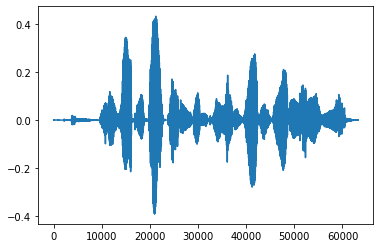

In [190]:
plt.plot(c)
plt.show()

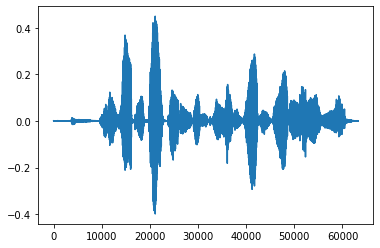

In [191]:
from matplotlib import pyplot as plt
plt.plot(rx1)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

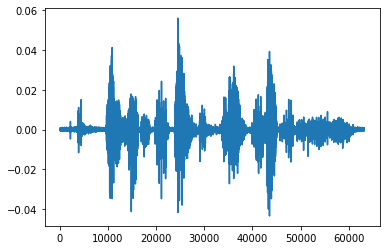

In [192]:
plt.plot(c-rx1)
plt.show

In [203]:
model.means

tensor([[0.9569, 0.8267, 0.5277, 0.7265, 0.9281, 0.7253, 0.3994, 0.5028, 0.8167,
         0.0794, 0.0015, 0.7470, 0.2387, 0.4907, 0.8403, 0.7493, 0.8345, 0.2153,
         0.2770, 0.4149, 0.4111, 0.1433, 0.5061, 0.2412, 0.5849, 0.7618, 0.2375,
         0.6189, 0.6281, 0.3993, 0.2705, 0.4782, 0.5395, 0.3819, 0.3690, 0.1435,
         0.9499, 0.7238, 0.4912, 0.6182, 0.7107, 0.2196, 0.1657, 0.1442, 0.1659,
         0.1883, 0.4656, 0.0121, 0.8716, 0.4336, 0.2395, 0.4590, 0.9423, 0.4589,
         0.6027, 0.5323, 0.9051, 0.2686, 0.0271, 0.7921, 0.9978, 0.0287, 0.2145,
         0.1823]], device='cuda:0', requires_grad=True)

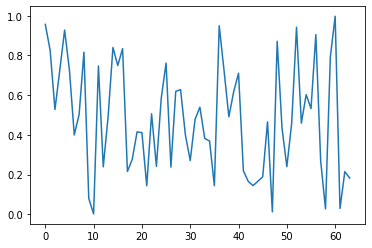

In [200]:
plt.plot(model.means.cpu().data.numpy()[0])

In [178]:
rx1 = torch.tensor(rx1)
# x = torch.tensor(x)
# SDR(rx1, x)

c = torch.tensor(c)
SDR(rx1, c)

16.050520663285297

In [83]:
model.means

tensor([[0.0110, 0.5344, 0.4529, 0.4005, 0.7564, 0.1621, 0.1094, 0.6369, 0.2735,
         0.1288, 0.1617, 0.0207, 0.4673, 0.1808, 0.9108, 0.3285, 0.4358, 0.3809,
         0.5356, 0.9523, 0.2449, 0.6507, 0.1678, 0.9126, 0.4140, 0.4238, 0.3884,
         0.8546, 0.9221, 0.6628, 0.6618, 0.9961]], device='cuda:0',
       requires_grad=True)

In [82]:
if window_in_data:
    test_path = '../data/1116_0db_global_test.pth'
else:
    test_path = '../data/1117_0db_global_noWindow_test.pth'
    
test_loader = torch.load(test_path)
for data in test_loader:
    wave_s, wave_x, source, mixture = data
    break
x = wave_x[0].cpu().data.numpy()
ipd.Audio(x/max(abs(x)), rate = 16000)

# librosa.output.write_wav('../testuttr/uttr1_stage0_base.wav', rx1/max(rx1), 16000)

In [95]:
rx = rebuild_window(source[0])

In [96]:
ipd.Audio(rx/max(abs(rx)), rate = 16000)

In [83]:
rs1, rx1 = generate_result(model_stage0, mixture[0], window_in_data=window_in_data)
ipd.Audio(rx1/max(abs(rx1)), rate = 16000)

In [55]:
x = torch.tensor(x).cuda()
rx1 = torch.tensor(rx1).cuda()
SDR(rx1, x)

24.396603873745516